# Cleaning ICBC Accident Data for Vancouver

## Introduction

In British Columbia, car insurance is provided by a single crown corporation: Insurance Corporation of British Columbia (ICBC).  As a result of being a crown corporation, they are beholden to open data policies within the province similar to a government agency.  As such, a significant amount of data about the accidents that occur in the province is made available and can be found [HERE](https://www.icbc.com/about-icbc/newsroom/Pages/Statistics.aspx)

Much of the data can be broken down regionally in BC, or by municipality.  Being a Vancouver resident, I am aware that there are a number of unique neighborhoods and communities, 22 in all, within Vancouver.  Given the number of unique neighborhoods in Vancouver, I wanted to see if **there are any trends or insights that could be made about ICBC reported accidents at the neighborhood level in Vancouver.**

The neighborhood information had to be added into the data that was available.  This required taking separate coordinate data from the city of Vancouver that provides the boundaries for each neighborhood.  This can be found [HERE](https://opendata.vancouver.ca/explore/dataset/local-area-boundary/export/?disjunctive.name).

For this project, the primary analysis will be done in MySQL.  In preparation for that analysis, this is what will be accomplished in this notebook:

1. Cleaning the Vancouver Neighborhood Coordinate data in order to make 2-D boundaries for each neighborhood
2. Use the coordinates in the Accident Data to label each with the the neighborhood that it occured in
3. Cleaning of the finalized Accident Data to remove duplicative or redundent data in preparation for analysis

## Table of Contents

1. [Cleaning Vancouver Neighborhood Data](#neighborhood)
2. [Labeling the Neighborhood of Each Accident](#labeling)
3. [Preliminary Data Cleaning](#cleaning)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Polygon used to create shapes of the neighborhoods
from shapely.geometry.polygon import Polygon

#Point used to compare accident coordinates to the Polygon shape and label neighborhoods
from shapely.geometry import Point

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', None)

## Cleaning Vancouver Neighborhood Data

<a id = 'neighborhood'></a>

In [4]:
df = pd.read_csv('Raw Data/local-area-boundary.csv', on_bad_lines='skip')

When inputting the data in this fashion, it is later revealed that the 'Shaughnessy' neighborhood line of data was not able to be read through in this process.  This is fixed when the neighborhood labels are applied to the accident data.

In [5]:
df = df.reset_index()
df = df.set_index('level_0')
df.head()

,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10,level_11,level_12,level_13,level_14,level_15,level_16,level_17,level_18,level_19,level_20,level_21,level_22,level_23,level_24,level_25,level_26,level_27,level_28,level_29,level_30,level_31,level_32,level_33,level_34,level_35,level_36,level_37,level_38,level_39,level_40,level_41,level_42,level_43,level_44,level_45,level_46,level_47,level_48,level_49,level_50,level_51,level_52,level_53,level_54,level_55,level_56,level_57,level_58,level_59,level_60,level_61,level_62,level_63,level_64,level_65,level_66,level_67,level_68,level_69,level_70,level_71,level_72,level_73,level_74,level_75,level_76,level_77,level_78,level_79,level_80,level_81,level_82,level_83,level_84,level_85,level_86,level_87,level_88,level_89,level_90,level_91,level_92,level_93,level_94,level_95,level_96,level_97,level_98,level_99,level_100,level_101,level_102,level_103,level_104,level_105,level_106,level_107,level_108,level_109,level_110,level_111,level_112,level_113,level_114,level_115,level_116,level_117,level_118,level_119,level_120,level_121,level_122,level_123,level_124,level_125,level_126,level_127,level_128,level_129,level_130,level_131,level_132,level_133,level_134,level_135,level_136,level_137,level_138,level_139,level_140,level_141,level_142,level_143,level_144,level_145,level_146,level_147,level_148,level_149,level_150,level_151,level_152,level_153,level_154,level_155,level_156,level_157,level_158,level_159,level_160,level_161,level_162,level_163,level_164,level_165,level_166,level_167,level_168,level_169,level_170,level_171,level_172,level_173,level_174,level_175,level_176,level_177,level_178,level_179,level_180,level_181,level_182,level_183,level_184,level_185,level_186,level_187,level_188,level_189,level_190,level_191,level_192,level_193,level_194,level_195,level_196,level_197,level_198,level_199,level_200,level_201,level_202,level_203,level_204,level_205,level_206,level_207,level_208,level_209,level_210,level_211,level_212,level_213,level_214,level_215,level_216,level_217,level_218,level_219,level_220,level_221,level_222,MAPID;Name;Geom;geo_point_2d
level_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"DS;Dunbar-Southlands;""{""""coordinates"""": [[[-123.17016601562499",49.24789047240798],[-123.17024993896482,49.23470306396071],[-123.17870330810545,49.23472213744702],[-123.17909240722653,49.216804504390375],[-123.17908477783202,49.215557098384515],[-123.17910003662107,49.215557098384515],[-123.17975616455075,49.21558761596264],[-123.18041229248044,49.2156372070271],[-123.1810607910156,49.21571350097242],[-123.18170166015622,49.215812683101305],[-123.18232727050778,49.21593475341382],[-123.18295288085935,49.21607971190991],[-123.18355560302733,49.2162475585896],[-123.18415069580075,49.21643447875562],[-123.1847229003906,49.21664428710522],[-123.18527984619139,49.21687316894117],[-123.18581390380857,49.21712112426342],[-123.18633270263669,49.217391967769295],[-123.18682098388669,49.21767807006421],[-123.18728637695311,49.217979431148194],[-123.18772888183591,49.21829986571849],[-123.18795013427733,49.21846389770093],[-123.1881866455078,49.21861648559156],[-123.18843841552732,49.21876144408764],[-123.18869781494138,49.21889877318919],[-123.18896484374999,49.219024658198975],[-123.18924713134764,49.219142913814196],[-123.18953704833983,49.21924972533764],[-123.18983459472653,49.21934890746656],[-123.19014739990233,49.219432830806404],[-123.1904602050781,49.21950912475172],[-123.19077301025388,49.21957397460523],[-123.19110107421872,49.21962356566967],[-123.19758605957028,49.220554351802484],[-123.19785308837889,49.220600128169664],[-123.19811248779295,49.22065353393138],[-123.19836425781247,49.2207183837849],[-123.19861602783202,49.22079086303296],[-123.19885253906247,49.2208747863728],[-123.199089050

Index is a bit of a mess, but the neighborhood names are inside of it.  I will primarily be using indexing and slicing in order to make the data appropriately readable for analysis.

First I will deal with the index, split the pieces and place them in the appropriate place.

In [6]:
df.index

Index(['DS;Dunbar-Southlands;"{""coordinates"": [[[-123.17016601562499',
       'KERR;Kerrisdale;"{""coordinates"": [[[-123.17908477783202',
       'KIL;Killarney;"{""coordinates"": [[[-123.0235595703125',
       'KITS;Kitsilano;"{""coordinates"": [[[-123.13768005371092',
       'SC;South Cambie;"{""coordinates"": [[[-123.1159896850586',
       'VF;Victoria-Fraserview;"{""coordinates"": [[[-123.0568313598633',
       'AR;Arbutus-Ridge;"{""coordinates"": [[[-123.15259552001953',
       'CBD;Downtown;"{""coordinates"": [[[-123.11226654052733',
       'FAIR;Fairview;"{""coordinates"": [[[-123.14598846435547',
       'GW;Grandview-Woodland;"{""coordinates"": [[[-123.07701873779298',
       'HS;Hastings-Sunrise;"{""coordinates"": [[[-123.05648803710938',
       'MARP;Marpole;"{""coordinates"": [[[-123.10696411132812',
       'RP;Riley Park;"{""coordinates"": [[[-123.10562133789061',
       'STR;Strathcona;"{""coordinates"": [[[-123.0992889404297',
       'WE;West End;"{""coordinates"": [[[-

In [7]:
# Each individual piece of data is separated by a ';'
index_list = list(df.index.str.split(';'))

In [8]:
index_list[0]

['DS', 'Dunbar-Southlands', '"{""coordinates"": [[[-123.17016601562499']

Each piece of the index has the following:
1. Abbrevation of the neighborhood.  This will not be kept.
2. Full neighborhood name.  This will become the new index for the data.
3. A string that contains "coordinates" followed by the first coordinate of the location.  This will be cleaned so that just the coordinate remains and is placed as the first column of the data.

In [9]:
#Make a list of just the neighborhood names
neighbourhood_list = []
for n in range(0,len(index_list)):
    neighbourhood = index_list[n][1]
    neighbourhood_list.append(neighbourhood)

In [10]:
neighbourhood_list

['Dunbar-Southlands',
 'Kerrisdale',
 'Killarney',
 'Kitsilano',
 'South Cambie',
 'Victoria-Fraserview',
 'Arbutus-Ridge',
 'Downtown',
 'Fairview',
 'Grandview-Woodland',
 'Hastings-Sunrise',
 'Marpole',
 'Riley Park',
 'Strathcona',
 'West End',
 'Kensington-Cedar Cottage',
 'Mount Pleasant',
 'Oakridge',
 'Renfrew-Collingwood',
 'Sunset',
 'West Point Grey']

In [11]:
# Finding the appropriate place to index to get just the coordinate number
index_list[0][2]

'"{""coordinates"": [[[-123.17016601562499'

In [12]:
index_list[0][2][-21:]

'[[-123.17016601562499'

In [13]:
coordinate_list = []
for n in range(0,len(index_list)):
    coordinate = index_list[n][2][-21:]
    coordinate_list.append(coordinate)

In [14]:
coordinate_list

['[[-123.17016601562499',
 '[[-123.17908477783202',
 '[[[-123.0235595703125',
 '[[-123.13768005371092',
 '[[[-123.1159896850586',
 '[[[-123.0568313598633',
 '[[-123.15259552001953',
 '[[-123.11226654052733',
 '[[-123.14598846435547',
 '[[-123.07701873779298',
 '[[-123.05648803710938',
 '[[-123.10696411132812',
 '[[-123.10562133789061',
 '[[[-123.0992889404297',
 '[[-123.13768005371092',
 '[[-123.05658721923828',
 '[[-123.10066986083984',
 '[[-123.10562133789061',
 '[[[-123.0235595703125',
 '[[-123.10696411132812',
 '[[-123.22444915771483']

Due to rounding, some coordinates have a different number of digits and '\['.  Indexing will be used to clean this further and match the rest of the data.

In [15]:
#Identifying rows that don't match
corrections = [2, 4, 5, 13, 18]

#Reverse indexing these rows to get the same number of '[' at the front of the coordinate
for n in corrections:
    coordinate_list[n] = coordinate_list[n][-20:]
    
coordinate_list

['[[-123.17016601562499',
 '[[-123.17908477783202',
 '[[-123.0235595703125',
 '[[-123.13768005371092',
 '[[-123.1159896850586',
 '[[-123.0568313598633',
 '[[-123.15259552001953',
 '[[-123.11226654052733',
 '[[-123.14598846435547',
 '[[-123.07701873779298',
 '[[-123.05648803710938',
 '[[-123.10696411132812',
 '[[-123.10562133789061',
 '[[-123.0992889404297',
 '[[-123.13768005371092',
 '[[-123.05658721923828',
 '[[-123.10066986083984',
 '[[-123.10562133789061',
 '[[-123.0235595703125',
 '[[-123.10696411132812',
 '[[-123.22444915771483']

With the neighborhood list and the coordinate list, we are ready to change the index and add the coordinates as the first column of data.

In [16]:
#Making index just the neighborhood names
df.index = neighbourhood_list

In [17]:
#Inserting coordinates into the first column of data
idx = 0
df.insert(loc=idx, column='level_0', value=coordinate_list)

In [18]:
df.head()

,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10,level_11,level_12,level_13,level_14,level_15,level_16,level_17,level_18,level_19,level_20,level_21,level_22,level_23,level_24,level_25,level_26,level_27,level_28,level_29,level_30,level_31,level_32,level_33,level_34,level_35,level_36,level_37,level_38,level_39,level_40,level_41,level_42,level_43,level_44,level_45,level_46,level_47,level_48,level_49,level_50,level_51,level_52,level_53,level_54,level_55,level_56,level_57,level_58,level_59,level_60,level_61,level_62,level_63,level_64,level_65,level_66,level_67,level_68,level_69,level_70,level_71,level_72,level_73,level_74,level_75,level_76,level_77,level_78,level_79,level_80,level_81,level_82,level_83,level_84,level_85,level_86,level_87,level_88,level_89,level_90,level_91,level_92,level_93,level_94,level_95,level_96,level_97,level_98,level_99,level_100,level_101,level_102,level_103,level_104,level_105,level_106,level_107,level_108,level_109,level_110,level_111,level_112,level_113,level_114,level_115,level_116,level_117,level_118,level_119,level_120,level_121,level_122,level_123,level_124,level_125,level_126,level_127,level_128,level_129,level_130,level_131,level_132,level_133,level_134,level_135,level_136,level_137,level_138,level_139,level_140,level_141,level_142,level_143,level_144,level_145,level_146,level_147,level_148,level_149,level_150,level_151,level_152,level_153,level_154,level_155,level_156,level_157,level_158,level_159,level_160,level_161,level_162,level_163,level_164,level_165,level_166,level_167,level_168,level_169,level_170,level_171,level_172,level_173,level_174,level_175,level_176,level_177,level_178,level_179,level_180,level_181,level_182,level_183,level_184,level_185,level_186,level_187,level_188,level_189,level_190,level_191,level_192,level_193,level_194,level_195,level_196,level_197,level_198,level_199,level_200,level_201,level_202,level_203,level_204,level_205,level_206,level_207,level_208,level_209,level_210,level_211,level_212,level_213,level_214,level_215,level_216,level_217,level_218,level_219,level_220,level_221,level_222,MAPID;Name;Geom;geo_point_2d
Dunbar-Southlands,[[-123.17016601562499,49.24789047240798],[-123.17024993896482,49.23470306396071],[-123.17870330810545,49.23472213744702],[-123.17909240722653,49.216804504390375],[-123.17908477783202,49.215557098384515],[-123.17910003662107,49.215557098384515],[-123.17975616455075,49.21558761596264],[-123.18041229248044,49.2156372070271],[-123.1810607910156,49.21571350097242],[-123.18170166015622,49.215812683101305],[-123.18232727050778,49.21593475341382],[-123.18295288085935,49.21607971190991],[-123.18355560302733,49.2162475585896],[-123.18415069580075,49.21643447875562],[-123.1847229003906,49.21664428710522],[-123.18527984619139,49.21687316894117],[-123.18581390380857,49.21712112426342],[-123.18633270263669,49.217391967769295],[-123.18682098388669,49.21767807006421],[-123.18728637695311,49.217979431148194],[-123.18772888183591,49.21829986571849],[-123.18795013427733,49.21846389770093],[-123.1881866455078,49.21861648559156],[-123.18843841552732,49.21876144408764],[-123.18869781494138,49.21889877318919],[-123.18896484374999,49.219024658198975],[-123.18924713134764,49.219142913814196],[-123.18953704833983,49.21924972533764],[-123.18983459472653,49.21934890746656],[-123.19014739990233,49.219432830806404],[-123.1904602050781,49.21950912475172],[-123.19077301025388,49.21957397460523],[-123.19110107421872,49.21962356566967],[-123.19758605957028,49.220554351802484],[-123.19785308837889,49.220600128169664],[-123.19811248779295,49.22065353393138],[-123.19836425781247,49.2207183837849],[-123.19861602783202,49.22079086303296],[-123.19885253906247,49.2208747863728],[-123.19908905029294,49.220966339107164],[-123.19931793212889,49.22106170653881],[-123.19953155517577,49.22116851806226],[-123.19974517822264,49.22128295898022],[-123.19994354248044,49.221405029292725],[-123.20550537109372,49.22499465941967],[-123.20590972900388,49.22

Unseen in the data above, there is actually a blank space in the front of every datapoint with the exception of 'level_0' as shown below.

In [19]:
print(df['level_0'][0][:])
print(df['level_0'][0][2:])

[[-123.17016601562499
-123.17016601562499


In [20]:
print(df['level_2'][0][:])
print(df['level_2'][0][2:])

 [-123.17024993896482
-123.17024993896482


I have kept the second '\[' in level_0 so that every data point can be accurately indexed together.  The longitudes will have the first two characters removed, the latitudes will have the last character removed, and this will result in just the number remaining.

In [21]:
#Even rows are longitudes
for n in range(0, 221, 2):
    name = 'level_'+str(n)
    df[name] = df[name].str[2:]

In [22]:
#Odd rows are latitudes
for n in range(1, 222, 2):
    name = 'level_'+str(n)
    df[name] = df[name].str[:-1]

In [23]:
df.head()

,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10,level_11,level_12,level_13,level_14,level_15,level_16,level_17,level_18,level_19,level_20,level_21,level_22,level_23,level_24,level_25,level_26,level_27,level_28,level_29,level_30,level_31,level_32,level_33,level_34,level_35,level_36,level_37,level_38,level_39,level_40,level_41,level_42,level_43,level_44,level_45,level_46,level_47,level_48,level_49,level_50,level_51,level_52,level_53,level_54,level_55,level_56,level_57,level_58,level_59,level_60,level_61,level_62,level_63,level_64,level_65,level_66,level_67,level_68,level_69,level_70,level_71,level_72,level_73,level_74,level_75,level_76,level_77,level_78,level_79,level_80,level_81,level_82,level_83,level_84,level_85,level_86,level_87,level_88,level_89,level_90,level_91,level_92,level_93,level_94,level_95,level_96,level_97,level_98,level_99,level_100,level_101,level_102,level_103,level_104,level_105,level_106,level_107,level_108,level_109,level_110,level_111,level_112,level_113,level_114,level_115,level_116,level_117,level_118,level_119,level_120,level_121,level_122,level_123,level_124,level_125,level_126,level_127,level_128,level_129,level_130,level_131,level_132,level_133,level_134,level_135,level_136,level_137,level_138,level_139,level_140,level_141,level_142,level_143,level_144,level_145,level_146,level_147,level_148,level_149,level_150,level_151,level_152,level_153,level_154,level_155,level_156,level_157,level_158,level_159,level_160,level_161,level_162,level_163,level_164,level_165,level_166,level_167,level_168,level_169,level_170,level_171,level_172,level_173,level_174,level_175,level_176,level_177,level_178,level_179,level_180,level_181,level_182,level_183,level_184,level_185,level_186,level_187,level_188,level_189,level_190,level_191,level_192,level_193,level_194,level_195,level_196,level_197,level_198,level_199,level_200,level_201,level_202,level_203,level_204,level_205,level_206,level_207,level_208,level_209,level_210,level_211,level_212,level_213,level_214,level_215,level_216,level_217,level_218,level_219,level_220,level_221,level_222,MAPID;Name;Geom;geo_point_2d
Dunbar-Southlands,-123.17016601562499,49.24789047240798,-123.17024993896482,49.23470306396071,-123.17870330810545,49.23472213744702,-123.17909240722653,49.216804504390375,-123.17908477783202,49.215557098384515,-123.17910003662107,49.215557098384515,-123.17975616455075,49.21558761596264,-123.18041229248044,49.2156372070271,-123.1810607910156,49.21571350097242,-123.18170166015622,49.215812683101305,-123.18232727050778,49.21593475341382,-123.18295288085935,49.21607971190991,-123.18355560302733,49.2162475585896,-123.18415069580075,49.21643447875562,-123.1847229003906,49.21664428710522,-123.18527984619139,49.21687316894117,-123.18581390380857,49.21712112426342,-123.18633270263669,49.217391967769295,-123.18682098388669,49.21767807006421,-123.18728637695311,49.217979431148194,-123.18772888183591,49.21829986571849,-123.18795013427733,49.21846389770093,-123.1881866455078,49.21861648559156,-123.18843841552732,49.21876144408764,-123.18869781494138,49.21889877318919,-123.18896484374999,49.219024658198975,-123.18924713134764,49.219142913814196,-123.18953704833983,49.21924972533764,-123.18983459472653,49.21934890746656,-123.19014739990233,49.219432830806404,-123.1904602050781,49.21950912475172,-123.19077301025388,49.21957397460523,-123.19110107421872,49.21962356566967,-123.19758605957028,49.220554351802484,-123.19785308837889,49.220600128169664,-123.19811248779295,49.22065353393138,-123.19836425781247,49.2207183837849,-123.19861602783202,49.22079086303296,-123.19885253906247,49.2208747863728,-123.19908905029294,49.220966339107164,-123.19931793212889,49.22106170653881,-123.19953155517577,49.22116851806226,-123.19974517822264,49.22128295898022,-123.19994354248044,49.221405029292725,-123.20550537109372,49.22499465941967,-123.20590972900388,49.22529983520093,-123.20629119873045,49.225616455073975,-123.20664215087888,49.22594451903882,-1

The last 3 columns still need some cleaning.  The third to last column still has ']]' for the final latitude.  The final two columns has what I believe to be the centroid location of the neighborhood shape.  This data will not be kept for this analysis and will be removed.

To faciliate this, I will transpose the dataframe, make a list of the coordinates and modify/remove the last 3 items of the listed coordinates before re-transposing the dataframe.

In [24]:
df = df.T

In [25]:
df.head()

,Dunbar-Southlands,Kerrisdale,Killarney,Kitsilano,South Cambie,Victoria-Fraserview,Arbutus-Ridge,Downtown,Fairview,Grandview-Woodland,Hastings-Sunrise,Marpole,Riley Park,Strathcona,West End,Kensington-Cedar Cottage,Mount Pleasant,Oakridge,Renfrew-Collingwood,Sunset,West Point Grey
level_0,-123.17016601562499,-123.17908477783202,-123.0235595703125,-123.13768005371092,-123.1159896850586,-123.0568313598633,-123.15259552001953,-123.11226654052733,-123.14598846435547,-123.07701873779298,-123.05648803710938,-123.10696411132812,-123.10562133789061,-123.0992889404297,-123.13768005371092,-123.05658721923828,-123.10066986083984,-123.10562133789061,-123.0235595703125,-123.10696411132812,-123.22444915771483
level_1,49.24789047240798,49.215557098384515,49.2001457214314,49.27531814574782,49.237937927241944,49.20420074462476,49.25722503661694,49.29016494750564,49.25712203979079,49.29024887084548,49.293487548824,49.20415878295483,49.23311614989819,49.28927230834548,49.27531814574782,49.26198196410718,49.269130706782974,49.23311614989819,49.2347908019978,49.20415878295483,49.27892303466384
level_2,-123.17024993896482,-123.17563629150389,-123.03997802734376,-123.14374542236328,-123.1161651611328,-123.05846405029298,-123.16487884521483,-123.10424041748047,-123.14540100097656,-123.06777954101564,-123.0519027709961,-123.11153411865233,-123.1161651611328,-123.09390258789064,-123.14125823974611,-123.05662536621094,-123.09692382812501,-123.10616302490234,-123.02356719970705,-123.10616302490234,-123.20515441894527
level_3,49.23470306396071,49.2153701782185,49.203960418697015,49.27323150634351,49.233489990230225,49.20421981811106,49.25742721557202,49.28816604613845,49.2718467712361,49.29010391234939,49.29414749145095,49.20444488524975,49.233489990230225,49.29051589965409,49.27829360961501,49.24317550658764,49.26700592040602,49.218875885005616,49.23226928710523,49.218875885005616,49.27805709838453
level_4,-123.17870330810545,-123.17217254638669,-123.04232025146484,-123.14389801025389,-123.12804412841797,-123.0594482421875,-123.16487884521483,-123.0992889404297,-123.14534759521486,-123.06262207031251,-123.046630859375,-123.11196899414062,-123.1159896850586,-123.07701873779298,-123.14267730712892,-123.05811309814453,-123.09688568115234,-123.14015197753906,-123.03034210205078,-123.10562133789061,-123.18941497802733


In [26]:
#New Dataframe will be made to add the modified lists to
df2 = pd.DataFrame(columns = df.columns)

In [27]:
for n in df.columns:
    #Creating list of coordinates for each neighborhood
    listed = list(df[n])
    length = len(listed)
    
    #With differing lengths of coordinates, index relative to the length of the specific neighborhood's list
    for item in range(0, length-2):
        
        #First find the item with ']]' at the end
        if str(listed[item]).endswith(']]'):
            
            #Remove the ']]'
            listed[item] = listed[item][:-2]
            
            #Delete the two list items after it
            del listed[item+2]
            del listed[item+1]
    
    #Add the modified list to the new dataframe
    df2[n] = listed

In [28]:
#Transpose this dataframe and inspect for the change in the last 3 columns
df2 = df2.T

In [29]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221
Dunbar-Southlands,-123.17016601562499,49.24789047240798,-123.17024993896482,49.23470306396071,-123.17870330810545,49.23472213744702,-123.17909240722653,49.216804504390375,-123.17908477783202,49.215557098384515,-123.17910003662107,49.215557098384515,-123.17975616455075,49.21558761596264,-123.18041229248044,49.2156372070271,-123.1810607910156,49.21571350097242,-123.18170166015622,49.215812683101305,-123.18232727050778,49.21593475341382,-123.18295288085935,49.21607971190991,-123.18355560302733,49.2162475585896,-123.18415069580075,49.21643447875562,-123.1847229003906,49.21664428710522,-123.18527984619139,49.21687316894117,-123.18581390380857,49.21712112426342,-123.18633270263669,49.217391967769295,-123.18682098388669,49.21767807006421,-123.18728637695311,49.217979431148194,-123.18772888183591,49.21829986571849,-123.18795013427733,49.21846389770093,-123.1881866455078,49.21861648559156,-123.18843841552732,49.21876144408764,-123.18869781494138,49.21889877318919,-123.18896484374999,49.219024658198975,-123.18924713134764,49.219142913814196,-123.18953704833983,49.21924972533764,-123.18983459472653,49.21934890746656,-123.19014739990233,49.219432830806404,-123.1904602050781,49.21950912475172,-123.19077301025388,49.21957397460523,-123.19110107421872,49.21962356566967,-123.19758605957028,49.220554351802484,-123.19785308837889,49.220600128169664,-123.19811248779295,49.22065353393138,-123.19836425781247,49.2207183837849,-123.19861602783202,49.22079086303296,-123.19885253906247,49.2208747863728,-123.19908905029294,49.220966339107164,-123.19931793212889,49.22106170653881,-123.19953155517577,49.22116851806226,-123.19974517822264,49.22128295898022,-123.19994354248044,49.221405029292725,-123.20550537109372,49.22499465941967,-123.20590972900388,49.22529983520093,-123.20629119873045,49.225616455073975,-123.20664215087888,49.22594451903882,-123.20697021484372,49.22628784179272,-123.20726776123045,49.226638793941156,-123.20754241943355,49.227001190181376,-123.20888519287107,49.228946685786866,-123.20916748046872,49.229259490962654,-123.2094802856445,49.22956085204663,-123.20982360839841,49.229846954341554,-123.21018218994138,49.23012161254467,-123.21057128906249,49.230381011958734,-123.21098327636716,49.23062515258374,-123.21141815185544,49.23085403441967,-123.219856262207,49.23502349853101,-123.22194671630858,49.236576080318116,-123.21992492675778,49.23954772948803,-123.20859527587888,49.23518371581616,-123.20560455322264,49.237201690669686,-123.19683074951169,49.23485565185131,-123.19685363769528,49.23651504516186,-123.19857025146482,49.23651885985914,-123.19857025146482,49.238346099849366,-123.19685363769528,49.23847961425365,-123.1967849731445,49.24619674682202,-123.19854736328122,49.24620819091382,-123.19858551025389,49.24620819091383,-123.19863128662108,49.24620819091383,-123.19867706298827,49.24621200561109,-123.19871520996091,49.24621582030837,-123.1987609863281,49.24622344970289,-123.19879913330077,49.24623107909742,-123.19884490966795,49.24623870849194,-123.1988830566406,49.24624633788648,-123.19892120361327,49.24625778197829,-123.19895935058591,49.24627304076734,-123.19899749755857,49.246288299556404,-123.19903564453124,49.2462997436482,-123.19906616210935,49.24631881713453,-1

Here we have cleaned up the coordinates, but there is still a few things needed to be prepared for making Polygons. To do so, I will do the following:

1. To facilitate future calculations and transformations considering there are a different number of coordinates for each neighborhood, I will change all of the Nan values to 0's.
2. I will create new columns that will include the X and Y coordinates as a tuple.
3. Then I will keep only the columns that have the full coordinates.

In [30]:
#Replacing nan's with 0's, this will help ensure every future tuple is treated as a float.
df2 = df2.replace(np.nan,0)

In [31]:
#Ensuring column names are strings so they can be edited with ease later.
df2.columns = df2.columns.astype(str)

In [32]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, Dunbar-Southlands to West Point Grey
Columns: 222 entries, 0 to 221
dtypes: object(222)
memory usage: 37.1+ KB


In [33]:
#All datapoints are objects and now need to be converted to numeric values prior to creating tuples.
for col in df2.columns:
    try:
        df2[col] = pd.to_numeric(df2[col])
    except:
        pass

In [34]:
#Confirming all data has been turned into floats
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, Dunbar-Southlands to West Point Grey
Columns: 222 entries, 0 to 221
dtypes: float64(222)
memory usage: 37.1+ KB


In [35]:
#Get the length of the columns
column_length = len(df2.columns)

#Counter to help appropriately name new columns
count = 1

for n in range(0, column_length, 2):
    #Creating new column name
    column_number = (f'Coordinate #'+str(count))
    
    #Collecting longitude
    x_coor = df2.columns[n]
    
    #Collecting the matching latitude in following column
    y_coor = df2.columns[n+1]
    
    #Creating new column with the coordinates zipped together as a tuple
    df2[column_number] = list(zip(df2[x_coor], df2[y_coor]))
    
    #Increase count to rename the next column
    count += 1

In [36]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,Coordinate #1,Coordinate #2,Coordinate #3,Coordinate #4,Coordinate #5,Coordinate #6,Coordinate #7,Coordinate #8,Coordinate #9,Coordinate #10,Coordinate #11,Coordinate #12,Coordinate #13,Coordinate #14,Coordinate #15,Coordinate #16,Coordinate #17,Coordinate #18,Coordinate #19,Coordinate #20,Coordinate #21,Coordinate #22,Coordinate #23,Coordinate #24,Coordinate #25,Coordinate #26,Coordinate #27,Coordinate #28,Coordinate #29,Coordinate #30,Coordinate #31,Coordinate #32,Coordinate #33,Coordinate #34,Coordinate #35,Coordinate #36,Coordinate #37,Coordinate #38,Coordinate #39,Coordinate #40,Coordinate #41,Coordinate #42,Coordinate #43,Coordinate #44,Coordinate #45,Coordinate #46,Coordinate #47,Coordinate #48,Coordinate #49,Coordinate #50,Coordinate #51,Coordinate #52,Coordinate #53,Coordinate #54,Coordinate #55,Coordinate #56,Coordinate #57,Coordinate #58,Coordinate #59,Coordinate #60,Coordinate #61,Coordinate #62,Coordinate #63,Coordinate #64,Coordinate #65,Coordinate #66,Coordinate #67,Coordinate #68,Coordinate #69,Coordinate #70,Coordinate #71,Coordinate #72,Coordinate #73,Coordinate #74,Coordinate #75,Coordinate #76,Coordinate #77,Coordinate #78,Coordinate #79,Coordinate #80,Coordinate #81,Coordinate #82,Coordinate #83,Coordinate #84,Coordinate #85,Coordinate #86,Coordinate #87,Coordinate #88,Coordinate #89,Coordinate #90,Coordinate #91,Coordinate #92,Coordinate #93,Coordinate #94,Coordinate #95,Coordinate #96,Coordinate #97,Coordinate #98,Coordinate #99,Coordinate #100,Coordinate #101,Coordinate #102,Coordinate #103,Coordinate #104,Coordinate #105,Coordinate #106,Coordinate #107,Coordinate #108,Coordinate #109,Coordinate #110,Coordinate #111
Dunbar-Southlands,-123.170166,49.247890,-123.170250,49.234703,-123.178703,49.234722,-123.179092,49.216805,-123.179085,49.215557,-123.179100,49.215557,-123.179756,49.215588,-123.180412,49.215637,-123.181061,49.215714,-123.181702,49.215813,-123.182327,49.215935,-123.182953,49.216080,-123.183556,49.216248,-123.184151,49.216434,-123.184723,49.216644,-123.185280,49.216873,-123.185814,49.217121,-123.186333,49.217392,-123.186821,49.217678,-123.187286,49.217979,-123.187729,49.218300,-123.187950,49.218464,-123.188187,49.218616,-123.188438,49.218761,-123.188698,49.218899,-123.188965,49.219025,-123.189247,49.219143,-123.189537,49.219250,-123.189835,49.219349,-123.190147,49.219433,-123.190460,49.219509,-123.190773,49.219574,-123.191101,49.219624,-123.197586,49.220554,-123.197853,49.220600,-123.198112,49.220654,-123.198364,49.220718,-123.198616,49.220791,-123.198853,49.220875,-123.199089,49.220966,-123.199318,49.221062,-123.199532,49.221169,-123.199745,49.221283,-123.199944,49.221405,-123.205505,49.224995,-123.205910,49.225300,-123.206291,49.225616,-123.206642,49.225945,-123.206970,49.226288,-123.207268,49.226639,-123.207542,49.227001,-123.208885,49.228947,-123.209167,49.229259,-123.209480,49.229561,-123.209824,49.229847,-123.210182,49.230122,-123.210571,49.230381,-123.210983,49.230625,-123.211418,49.230854,-123.219856,49.235023,-123.221947,49.236576,-123.219925,49.239548,-123.208595,49.235184,-123.205605,49.237202,-123.196831,49.234856,-123.196854,49.236515,-123.198570,49.236519,-123.198570,49.238346,-123.196854,49.238480,-123.196785,49.24

In [37]:
df2.iloc[:,222:].T.head()

,Dunbar-Southlands,Kerrisdale,Killarney,Kitsilano,South Cambie,Victoria-Fraserview,Arbutus-Ridge,Downtown,Fairview,Grandview-Woodland,Hastings-Sunrise,Marpole,Riley Park,Strathcona,West End,Kensington-Cedar Cottage,Mount Pleasant,Oakridge,Renfrew-Collingwood,Sunset,West Point Grey
Coordinate #1,"(-123.170166015625, 49.24789047240798)","(-123.17908477783202, 49.21555709838452)","(-123.0235595703125, 49.2001457214314)","(-123.13768005371092, 49.27531814574782)","(-123.1159896850586, 49.23793792724194)","(-123.0568313598633, 49.20420074462476)","(-123.15259552001952, 49.25722503661694)","(-123.11226654052732, 49.29016494750564)","(-123.14598846435548, 49.25712203979079)","(-123.07701873779298, 49.29024887084548)","(-123.05648803710938, 49.293487548824)","(-123.10696411132812, 49.20415878295483)","(-123.1056213378906, 49.23311614989819)","(-123.0992889404297, 49.28927230834548)","(-123.13768005371092, 49.27531814574782)","(-123.05658721923828, 49.26198196410718)","(-123.10066986083984, 49.269130706782974)","(-123.1056213378906, 49.23311614989819)","(-123.0235595703125, 49.2347908019978)","(-123.10696411132812, 49.20415878295483)","(-123.22444915771484, 49.27892303466384)"
Coordinate #2,"(-123.17024993896482, 49.23470306396071)","(-123.17563629150388, 49.2153701782185)","(-123.03997802734376, 49.203960418697015)","(-123.14374542236328, 49.27323150634351)","(-123.1161651611328, 49.23348999023023)","(-123.05846405029298, 49.20421981811106)","(-123.16487884521484, 49.25742721557202)","(-123.10424041748048, 49.28816604613845)","(-123.14540100097656, 49.2718467712361)","(-123.06777954101564, 49.29010391234939)","(-123.0519027709961, 49.29414749145095)","(-123.11153411865232, 49.20444488524975)","(-123.1161651611328, 49.23348999023023)","(-123.09390258789064, 49.29051589965409)","(-123.14125823974612, 49.27829360961501)","(-123.05662536621094, 49.24317550658764)","(-123.096923828125, 49.26700592040602)","(-123.10616302490234, 49.218875885005616)","(-123.02356719970705, 49.23226928710523)","(-123.10616302490234, 49.218875885005616)","(-123.20515441894528, 49.27805709838453)"
Coordinate #3,"(-123.17870330810544, 49.23472213744702)","(-123.17217254638668, 49.215278625484125)","(-123.04232025146484, 49.20400238036693)","(-123.14389801025388, 49.2731781005818)","(-123.12804412841795, 49.23390579223219)","(-123.0594482421875, 49.20424270629467)","(-123.16487884521484, 49.25756835937086)","(-123.0992889404297, 49.28927230834548)","(-123.14534759521486, 49.27196121215408)","(-123.06262207031251, 49.2895355224568)","(-123.046630859375, 49.29418182372634)","(-123.11196899414062, 49.20445632934154)","(-123.1159896850586, 49.23793792724194)","(-123.07701873779298, 49.29024887084548)","(-123.14267730712892, 49.28133010863845)","(-123.05811309814452, 49.24182891845287)","(-123.09688568115234, 49.266975402827896)","(-123.14015197753906, 49.21930694579663)","(-123.03034210205078, 49.23193359374585)","(-123.1056213378906, 49.23311614989819)","(-123.18941497802732, 49.275215148921646)"
Coordinate #4,"(-123.17909240722652, 49.216804504390375)","(-123.17156982421874, 49.21524810790601)","(-123.0568313598633, 49.20420074462476)","(-123.14404296875, 49.27311706542555)","(-123.12721252441408, 49.25696945190016)","(-123.06043243408205, 49.20430374145092)","(-123.17807006835936, 49.25776672362869)","(-123.09999847412112, 49.272750854488045)","(-123.1452865600586, 49.27207565307204)","(-123.06242370605467, 49.29087448119704)","(-123.03739166259764, 49.2927322387654)","(-123.1124038696289, 49.204452514644274)","(-123.1159896850586, 49.238006591792725)","(-123.0774154663086, 49.26514053344312)","(-123.14553833007812, 49.28436279296462)","(-123.05819702148436, 49.24175262450756)","(-123.09683990478516, 49.26694869994703)","(-123.13959503173828, 49.234272003169686)","(-123.030517578125, 49.231929779048585)","(-123.09053802490232, 49.232822418208734)","(-123.18548583984374, 49.27497100829665)"
Coordinate #5,"(-123.17908477783202, 49.21555709838452)","(-123.17096710205

In [38]:
#New dataframe indexing just the tupled coordinates
coor_df = df2.iloc[:,222:].T

In [39]:
coor_df.head()

,Dunbar-Southlands,Kerrisdale,Killarney,Kitsilano,South Cambie,Victoria-Fraserview,Arbutus-Ridge,Downtown,Fairview,Grandview-Woodland,Hastings-Sunrise,Marpole,Riley Park,Strathcona,West End,Kensington-Cedar Cottage,Mount Pleasant,Oakridge,Renfrew-Collingwood,Sunset,West Point Grey
Coordinate #1,"(-123.170166015625, 49.24789047240798)","(-123.17908477783202, 49.21555709838452)","(-123.0235595703125, 49.2001457214314)","(-123.13768005371092, 49.27531814574782)","(-123.1159896850586, 49.23793792724194)","(-123.0568313598633, 49.20420074462476)","(-123.15259552001952, 49.25722503661694)","(-123.11226654052732, 49.29016494750564)","(-123.14598846435548, 49.25712203979079)","(-123.07701873779298, 49.29024887084548)","(-123.05648803710938, 49.293487548824)","(-123.10696411132812, 49.20415878295483)","(-123.1056213378906, 49.23311614989819)","(-123.0992889404297, 49.28927230834548)","(-123.13768005371092, 49.27531814574782)","(-123.05658721923828, 49.26198196410718)","(-123.10066986083984, 49.269130706782974)","(-123.1056213378906, 49.23311614989819)","(-123.0235595703125, 49.2347908019978)","(-123.10696411132812, 49.20415878295483)","(-123.22444915771484, 49.27892303466384)"
Coordinate #2,"(-123.17024993896482, 49.23470306396071)","(-123.17563629150388, 49.2153701782185)","(-123.03997802734376, 49.203960418697015)","(-123.14374542236328, 49.27323150634351)","(-123.1161651611328, 49.23348999023023)","(-123.05846405029298, 49.20421981811106)","(-123.16487884521484, 49.25742721557202)","(-123.10424041748048, 49.28816604613845)","(-123.14540100097656, 49.2718467712361)","(-123.06777954101564, 49.29010391234939)","(-123.0519027709961, 49.29414749145095)","(-123.11153411865232, 49.20444488524975)","(-123.1161651611328, 49.23348999023023)","(-123.09390258789064, 49.29051589965409)","(-123.14125823974612, 49.27829360961501)","(-123.05662536621094, 49.24317550658764)","(-123.096923828125, 49.26700592040602)","(-123.10616302490234, 49.218875885005616)","(-123.02356719970705, 49.23226928710523)","(-123.10616302490234, 49.218875885005616)","(-123.20515441894528, 49.27805709838453)"
Coordinate #3,"(-123.17870330810544, 49.23472213744702)","(-123.17217254638668, 49.215278625484125)","(-123.04232025146484, 49.20400238036693)","(-123.14389801025388, 49.2731781005818)","(-123.12804412841795, 49.23390579223219)","(-123.0594482421875, 49.20424270629467)","(-123.16487884521484, 49.25756835937086)","(-123.0992889404297, 49.28927230834548)","(-123.14534759521486, 49.27196121215408)","(-123.06262207031251, 49.2895355224568)","(-123.046630859375, 49.29418182372634)","(-123.11196899414062, 49.20445632934154)","(-123.1159896850586, 49.23793792724194)","(-123.07701873779298, 49.29024887084548)","(-123.14267730712892, 49.28133010863845)","(-123.05811309814452, 49.24182891845287)","(-123.09688568115234, 49.266975402827896)","(-123.14015197753906, 49.21930694579663)","(-123.03034210205078, 49.23193359374585)","(-123.1056213378906, 49.23311614989819)","(-123.18941497802732, 49.275215148921646)"
Coordinate #4,"(-123.17909240722652, 49.216804504390375)","(-123.17156982421874, 49.21524810790601)","(-123.0568313598633, 49.20420074462476)","(-123.14404296875, 49.27311706542555)","(-123.12721252441408, 49.25696945190016)","(-123.06043243408205, 49.20430374145092)","(-123.17807006835936, 49.25776672362869)","(-123.09999847412112, 49.272750854488045)","(-123.1452865600586, 49.27207565307204)","(-123.06242370605467, 49.29087448119704)","(-123.03739166259764, 49.2927322387654)","(-123.1124038696289, 49.204452514644274)","(-123.1159896850586, 49.238006591792725)","(-123.0774154663086, 49.26514053344312)","(-123.14553833007812, 49.28436279296462)","(-123.05819702148436, 49.24175262450756)","(-123.09683990478516, 49.26694869994703)","(-123.13959503173828, 49.234272003169686)","(-123.030517578125, 49.231929779048585)","(-123.09053802490232, 49.232822418208734)","(-123.18548583984374, 49.27497100829665)"
Coordinate #5,"(-123.17908477783202, 49.21555709838452)","(-123.17096710205

We now have a cleaned dataset where every column is the neighborhood and every row is the full longitude/latitude coordinate that is part of the border for each neighborhood.

With this we can now make Polygons for each neighborhood.  First I would like to test it.

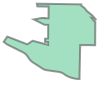

In [40]:
coord_list = coor_df['Dunbar-Southlands']
dunbar = Polygon(coord_list)
dunbar

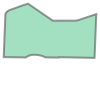

In [41]:
#Dunbar is the only neighborhood that does not have any (0,0) coordinates from previous Nan values
#I'll test again with a different neighborhood, only selecting relevant coordinates
fairview_coor = coor_df['Fairview'].loc[coor_df['Fairview'] != (0.0, 0.0)]
fairview = Polygon(fairview_coor)
fairview

Success!  The next step now will be to import the accident data and label each accident with the neighborhood that it occured in.

## Labeling the Neighborhood of Each Accident

<a id = 'labeling'></a>

In [42]:
#Inspecting through VS Code, this data has different encoding than the default for python
accident_df = pd.read_csv('Raw Data/bc_full_data.csv', encoding = 'utf-16 le', sep = '\t')

In [43]:
accident_df.head()

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash
0,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,SEPTEMBER,No,VANCOUVER,No,No,No,LOWER MAINLAND,GRANVILLE ST,06:00-08:59,VANCOUVER,GRANVILLE ST,GRANVILLE ST,1,1,1,NaN,49.286145,-123.112585,No
1,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,APRIL,No,VANCOUVER,No,No,No,LOWER MAINLAND,MAIN ST,06:00-08:59,VANCOUVER,MAIN ST,MAIN ST,1,1,2,NaN,49.285704,-123.099437,No
2,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,UNDETERMINED,No,No,NOVEMBER,No,VANCOUVER,No,No,No,LOWER MAINLAND,CAMBIE ST,12:00-14:59,VANCOUVER,CAMBIE ST,CAMBIE ST,1,1,1,NaN,49.243412,-123.117483,No
3,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,CONFLICTED,No,No,MARCH,No,VANCOUVER,No,No,No,LOWER MAINLAND,TERMINAL AVE,15:00-17:59,VANCOUVER,TERMINAL AVE,TERMINAL AVE,1,1,1,NaN,49.271797,-123.094418,No
4,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,MAY,No,VANCOUVER,No,No,No,LOWER MAINLAND,DUNSMUIR VIADUCT,15:00-17:59,VANCOUVER,DUNSMUIR VIADUCT,DUNSMUIR VIADUCT,1,1,1,NaN,49.279664,-123.110266,No


In [44]:
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239373 entries, 0 to 239372
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Crash Breakdown 2            239373 non-null  object 
 1   Date Of Loss Year            239373 non-null  int64  
 2   Animal Flag                  239373 non-null  object 
 3   Crash Severity               239373 non-null  object 
 4   Cyclist Flag                 239373 non-null  object 
 5   Day Of Week                  239373 non-null  object 
 6   Derived Crash Configuration  239373 non-null  object 
 7   Heavy Veh Flag               239373 non-null  object 
 8   Intersection Crash           239373 non-null  object 
 9   Month Of Year                239373 non-null  object 
 10  Motorcycle Flag              239373 non-null  object 
 11  Municipality Name (ifnull)   239373 non-null  object 
 12  Parked Vehicle Flag          239373 non-null  object 
 13 

In [45]:
accident_df[accident_df['Latitude'].isna()].head()

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash
87,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,MARCH,No,VANCOUVER,No,No,No,LOWER MAINLAND,MAIN ST,00:00-02:59,VANCOUVER,MAIN ST,MAIN ST,1,1,1,NaN,NaN,NaN,No
91,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,FEBRUARY,No,VANCOUVER,No,No,No,LOWER MAINLAND,E 41ST AVE,06:00-08:59,VANCOUVER,E 41ST AVE,E 41ST AVE,1,1,1,NaN,NaN,NaN,No
92,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,FEBRUARY,No,VANCOUVER,No,No,No,LOWER MAINLAND,E HASTINGS ST,06:00-08:59,VANCOUVER,UNKNOWN,E HASTINGS ST,1,1,1,MACLEAN DR,NaN,NaN,No
95,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,FEBRUARY,No,VANCOUVER,No,No,No,LOWER MAINLAND,2ND NARROWS BRIDGE,06:00-08:59,VANCOUVER,2ND NARROWS BRIDGE,2ND NARROWS BRIDGE,1,1,2,NaN,NaN,NaN,No
96,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,JANUARY,No,VANCOUVER,No,No,No,LOWER MAINLAND,MAIN ST,06:00-08:59,VANCOUVER,UNKNOWN,MAIN ST,1,1,1,57 AVE,NaN,NaN,No


In [46]:
print(f'{round(accident_df["Latitude"].isna().sum()/accident_df.shape[0]*100, 2)}% of the accidents have Null Location data')

10.98% of the accidents have Null Location data


An initial inspection shows that some cleaning will be needed prior to analysis.

1. Numerous columns look to be redundent, but will need to be confirmed.

2. Nearly 11% of the data does not have location information.  This is a sizeable chunk of the data, but there is no effective way to fill this data based on the information available at this time.  We will still have +200K accidents with locations, so the accidents with null values will be dropped.

3. Some reorganization of the data will likely be helpful.  This will be done when the data is imported into SQL.

I will drop the null values first, and then label each accident with the appropriate neighborhood.

In [47]:
#Confirming that Latitude and Longitude are both null in the same rows
accident_df[accident_df['Latitude'].isna() & accident_df['Longitude'].notna()]

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash


In [48]:
#New dataframe including only values that are notna in Latitude and resetting the index
accident_df = accident_df[accident_df['Latitude'].notna()]
accident_df = accident_df.reset_index(drop = True)
accident_df.head()

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash
0,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,SEPTEMBER,No,VANCOUVER,No,No,No,LOWER MAINLAND,GRANVILLE ST,06:00-08:59,VANCOUVER,GRANVILLE ST,GRANVILLE ST,1,1,1,NaN,49.286145,-123.112585,No
1,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,APRIL,No,VANCOUVER,No,No,No,LOWER MAINLAND,MAIN ST,06:00-08:59,VANCOUVER,MAIN ST,MAIN ST,1,1,2,NaN,49.285704,-123.099437,No
2,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,UNDETERMINED,No,No,NOVEMBER,No,VANCOUVER,No,No,No,LOWER MAINLAND,CAMBIE ST,12:00-14:59,VANCOUVER,CAMBIE ST,CAMBIE ST,1,1,1,NaN,49.243412,-123.117483,No
3,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,CONFLICTED,No,No,MARCH,No,VANCOUVER,No,No,No,LOWER MAINLAND,TERMINAL AVE,15:00-17:59,VANCOUVER,TERMINAL AVE,TERMINAL AVE,1,1,1,NaN,49.271797,-123.094418,No
4,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,MAY,No,VANCOUVER,No,No,No,LOWER MAINLAND,DUNSMUIR VIADUCT,15:00-17:59,VANCOUVER,DUNSMUIR VIADUCT,DUNSMUIR VIADUCT,1,1,1,NaN,49.279664,-123.110266,No


In [49]:
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213085 entries, 0 to 213084
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Crash Breakdown 2            213085 non-null  object 
 1   Date Of Loss Year            213085 non-null  int64  
 2   Animal Flag                  213085 non-null  object 
 3   Crash Severity               213085 non-null  object 
 4   Cyclist Flag                 213085 non-null  object 
 5   Day Of Week                  213085 non-null  object 
 6   Derived Crash Configuration  213085 non-null  object 
 7   Heavy Veh Flag               213085 non-null  object 
 8   Intersection Crash           213085 non-null  object 
 9   Month Of Year                213085 non-null  object 
 10  Motorcycle Flag              213085 non-null  object 
 11  Municipality Name (ifnull)   213085 non-null  object 
 12  Parked Vehicle Flag          213085 non-null  object 
 13 

In order to label the accidents with the appropriate neighborhood, I will create a dictionary that has the neighborhood as the key and the Polygon shape as the value.  Then I can look at each accident, capture its coordinates and cycle through each dictionary item to identify which neighborhood the accident was located in.

In [50]:
#Empty Dictionary to start
neighborhood_dict = {}

for n, neighborhood in enumerate(coor_df):
    #Robust selection of the coordinates for each neighborhood, not including (0, 0) values
    coord_list = coor_df[neighborhood].loc[coor_df[neighborhood] != (0.0, 0.0)]
    
    #Make Polygon for the neighborhood
    polygon = Polygon(coord_list)
    
    #Append dictionary by indexing the column names as the keys and the polygon as the values
    neighborhood_dict[coor_df.columns[n]] = polygon

In [51]:
neighborhood_dict

{'Dunbar-Southlands': <shapely.geometry.polygon.Polygon at 0x7fb923085100>,
 'Kerrisdale': <shapely.geometry.polygon.Polygon at 0x7fb923085c40>,
 'Killarney': <shapely.geometry.polygon.Polygon at 0x7fb923085460>,
 'Kitsilano': <shapely.geometry.polygon.Polygon at 0x7fb923085340>,
 'South Cambie': <shapely.geometry.polygon.Polygon at 0x7fb923085220>,
 'Victoria-Fraserview': <shapely.geometry.polygon.Polygon at 0x7fb923085d60>,
 'Arbutus-Ridge': <shapely.geometry.polygon.Polygon at 0x7fb923085eb0>,
 'Downtown': <shapely.geometry.polygon.Polygon at 0x7fb923085fd0>,
 'Fairview': <shapely.geometry.polygon.Polygon at 0x7fb923085f40>,
 'Grandview-Woodland': <shapely.geometry.polygon.Polygon at 0x7fb923085670>,
 'Hastings-Sunrise': <shapely.geometry.polygon.Polygon at 0x7fb923088310>,
 'Marpole': <shapely.geometry.polygon.Polygon at 0x7fb923088460>,
 'Riley Park': <shapely.geometry.polygon.Polygon at 0x7fb9230885b0>,
 'Strathcona': <shapely.geometry.polygon.Polygon at 0x7fb923088700>,
 'West E

In [52]:
#Creating new column to input the neighborhood data
#Set as N/A initially to check transformation afterwards
accident_df['Neighborhood'] = 'N/A'

In [53]:
#Labeling the neighborhood to the accident dataframe
for row in range(0, len(accident_df)):
    #Find the accident's coordinates and place them into Point
    long = accident_df['Longitude'][row]
    lat = accident_df['Latitude'][row]
    point = Point(long, lat)
    
    #Loop through each neighborhood
    for n in neighborhood_dict.keys():
        #If the Point is inside the neighborhood Polygon, return True and label the row with the neighborhood
        if neighborhood_dict[n].contains(point) == True:
            accident_df['Neighborhood'][row] = n

In [54]:
accident_df.head()

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash,Neighborhood
0,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,SEPTEMBER,No,VANCOUVER,No,No,No,LOWER MAINLAND,GRANVILLE ST,06:00-08:59,VANCOUVER,GRANVILLE ST,GRANVILLE ST,1,1,1,NaN,49.286145,-123.112585,No,Downtown
1,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,APRIL,No,VANCOUVER,No,No,No,LOWER MAINLAND,MAIN ST,06:00-08:59,VANCOUVER,MAIN ST,MAIN ST,1,1,2,NaN,49.285704,-123.099437,No,Strathcona
2,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,UNDETERMINED,No,No,NOVEMBER,No,VANCOUVER,No,No,No,LOWER MAINLAND,CAMBIE ST,12:00-14:59,VANCOUVER,CAMBIE ST,CAMBIE ST,1,1,1,NaN,49.243412,-123.117483,No,Riley Park
3,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,CONFLICTED,No,No,MARCH,No,VANCOUVER,No,No,No,LOWER MAINLAND,TERMINAL AVE,15:00-17:59,VANCOUVER,TERMINAL AVE,TERMINAL AVE,1,1,1,NaN,49.271797,-123.094418,No,Strathcona
4,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,MAY,No,VANCOUVER,No,No,No,LOWER MAINLAND,DUNSMUIR VIADUCT,15:00-17:59,VANCOUVER,DUNSMUIR VIADUCT,DUNSMUIR VIADUCT,1,1,1,NaN,49.279664,-123.110266,No,Downtown


In [55]:
accident_df['Neighborhood'].value_counts()

Downtown                    30516
Mount Pleasant              20083
Fairview                    16253
Renfrew-Collingwood         14633
Kensington-Cedar Cottage    13128
Sunset                      12204
Grandview-Woodland          11306
Kitsilano                   10911
Hastings-Sunrise            10791
Marpole                      9689
West End                     9151
Riley Park                   8132
Strathcona                   7912
N/A                          7187
Victoria-Fraserview          5520
Killarney                    4969
Oakridge                     4592
Dunbar-Southlands            3564
South Cambie                 3522
Arbutus-Ridge                3218
West Point Grey              3105
Kerrisdale                   2699
Name: Neighborhood, dtype: int64

I suspect that the N/A values are located in Shaughnessy and this is the result of skipping the bad lines when importing the initial data.  I will inspect this more closely.

In [56]:
accident_df[accident_df['Neighborhood'] =='N/A'].head()

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash,Neighborhood
37,VANCOUVER,2017,No,CASUALTY CRASH,No,WEDNESDAY,SINGLE VEHICLE,No,No,SEPTEMBER,No,VANCOUVER,No,No,No,LOWER MAINLAND,STANLEY PARK DR,09:00-11:59,VANCOUVER,STANLEY PARK DR,STANLEY PARK DR,1,1,3,NaN,49.301964,-123.153922,No,N/A
38,VANCOUVER,2017,No,CASUALTY CRASH,No,WEDNESDAY,UNDETERMINED,No,No,JUNE,No,VANCOUVER,No,No,No,LOWER MAINLAND,W 35TH AVE,09:00-11:59,VANCOUVER,W 35TH AVE,W 35TH AVE,1,1,1,NaN,49.239981,-123.147862,No,N/A
91,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,FEBRUARY,No,VANCOUVER,No,No,No,LOWER MAINLAND,OAK ST BRIDGE,06:00-08:59,VANCOUVER,OAK ST BRIDGE,OAK ST BRIDGE,1,1,1,NaN,49.198785,-123.124732,No,N/A
97,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,JULY,No,VANCOUVER,No,No,No,LOWER MAINLAND,OAK ST BRIDGE,12:00-14:59,VANCOUVER,OAK ST BRIDGE,OAK ST BRIDGE,1,1,1,NaN,49.198785,-123.124732,No,N/A
101,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,DECEMBER,No,VANCOUVER,No,No,No,LOWER MAINLAND,OAK ST BRIDGE,15:00-17:59,VANCOUVER,OAK ST BRIDGE,OAK ST BRIDGE,1,1,1,NaN,49.198785,-123.124732,No,N/A


This is mostly accurate, but inspecting separately using Tableau there is some other areas that are mislabeled:

1. The Stanley Park area is not assigned a location.  While technically this would be located in the 'West End' from an analysis point of view this does not seem appropriate as the traffic patterns between the West End and Stanley Park are very different.  Accidents that fall in this area will be labeled with Stanley Park

2. There are a number of bridges in Vancouver, but only accidents that happened on the Oak Street Bridge seems to be mislabeled.  The Oak Street bridge leads into the Marpole neighborhood, so these will be labeled as such.

3. A small collection of accidents along Boundary Road (which is the border between Vancouver and Burnaby) are unclassified.  Depending on the location, these either belong to the Killarney or the Renfrew-Collingwood neighborhoods.

4. Another small collection that are near UBC (which is outside of the jurisdiction for the City of Vancouver) are also mislabeled.  Depending of the location, these either belong to West Point Grey or Dunbar-Southlands

5. The remainder appear to be Shaughnessy.

We will correct these here.

In [57]:
#Default all N/A's to Shaughnessy
accident_df.loc[(accident_df['Neighborhood'] =='N/A'), 'Neighborhood'] = 'Shaughnessy'

In [58]:
#Using the most northern points to reclassify as Stanley Park
accident_df.loc[(accident_df['Neighborhood'] =='Shaughnessy') 
                & (accident_df['Latitude'] > 49.289), 'Neighborhood'] = 'Stanley Park'

#Identifying OAK ST BRIDGE
accident_df.loc[(accident_df['Neighborhood'] =='Shaughnessy') 
                & (accident_df['Road Location Description'] == 'OAK ST BRIDGE'), 'Neighborhood'] = 'Marpole'

#Identifying Boundary Rd Neighborhoods
accident_df.loc[(accident_df['Neighborhood'] =='Shaughnessy') 
                & (accident_df['Longitude'] > -123.03)
                & (accident_df['Latitude'] >= 49.2325), 'Neighborhood'] = 'Renfrew-Collingwood'

accident_df.loc[(accident_df['Neighborhood'] =='Shaughnessy') 
                & (accident_df['Longitude'] > -123.03)
                & (accident_df['Latitude'] < 49.2325), 'Neighborhood'] = 'Killarney'

#Identifying Near UBC Neighborhoods
accident_df.loc[(accident_df['Neighborhood'] =='Shaughnessy') 
                & (accident_df['Longitude'] < -123.17)
                & (accident_df['Latitude'] > 49.2582), 'Neighborhood'] = 'West Point Grey'

accident_df.loc[(accident_df['Neighborhood'] =='Shaughnessy') 
                & (accident_df['Longitude'] < -123.17)
                & (accident_df['Latitude'] < 49.2582), 'Neighborhood'] = 'Dunbar-Southlands'

In [59]:
accident_df['Neighborhood'].value_counts()

Downtown                    30516
Mount Pleasant              20083
Fairview                    16253
Renfrew-Collingwood         14659
Kensington-Cedar Cottage    13128
Sunset                      12204
Grandview-Woodland          11306
Kitsilano                   10911
Hastings-Sunrise            10791
Marpole                     10040
West End                     9151
Riley Park                   8132
Strathcona                   7912
Shaughnessy                  6355
Victoria-Fraserview          5520
Killarney                    5026
Oakridge                     4592
Dunbar-Southlands            3598
South Cambie                 3522
Arbutus-Ridge                3218
West Point Grey              3121
Kerrisdale                   2699
Stanley Park                  348
Name: Neighborhood, dtype: int64

## Preliminary Data Cleaning

<a id = 'cleaning'></a>

We now have each accident accurately labeled with their neighborhood.  With this we are now going to remove redundent columns in preparation for analysis.

In [60]:
accident_df.head(1)

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash,Neighborhood
0,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,SEPTEMBER,No,VANCOUVER,No,No,No,LOWER MAINLAND,GRANVILLE ST,06:00-08:59,VANCOUVER,GRANVILLE ST,GRANVILLE ST,1,1,1,NaN,49.286145,-123.112585,No,Downtown


In [61]:
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213085 entries, 0 to 213084
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Crash Breakdown 2            213085 non-null  object 
 1   Date Of Loss Year            213085 non-null  int64  
 2   Animal Flag                  213085 non-null  object 
 3   Crash Severity               213085 non-null  object 
 4   Cyclist Flag                 213085 non-null  object 
 5   Day Of Week                  213085 non-null  object 
 6   Derived Crash Configuration  213085 non-null  object 
 7   Heavy Veh Flag               213085 non-null  object 
 8   Intersection Crash           213085 non-null  object 
 9   Month Of Year                213085 non-null  object 
 10  Motorcycle Flag              213085 non-null  object 
 11  Municipality Name (ifnull)   213085 non-null  object 
 12  Parked Vehicle Flag          213085 non-null  object 
 13 

In [62]:
accident_df[accident_df['Municipality Name'] != accident_df['Crash Breakdown 2']]

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash,Neighborhood


In [63]:
accident_df[accident_df['Region'] != 'LOWER MAINLAND']

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash,Neighborhood


In [64]:
accident_df[accident_df['Street Full Name (ifnull)'] != accident_df['Street Full Name']]

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash,Neighborhood


In [65]:
accident_df[accident_df['Municipality Name (ifnull)'] != accident_df['Municipality Name']]

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash,Neighborhood


In [66]:
accident_df[accident_df['Metric Selector'] != accident_df['Total Crashes']]

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash,Neighborhood


In [67]:
accident_df[accident_df['Road Location Description'] != accident_df['Street Full Name']].head()

,Crash Breakdown 2,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Municipality Name (ifnull),Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Region,Street Full Name (ifnull),Time Category,Municipality Name,Road Location Description,Street Full Name,Metric Selector,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash,Neighborhood
1057,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,CONFLICTED,No,Yes,JULY,No,VANCOUVER,No,No,No,LOWER MAINLAND,CLARK DR,00:00-02:59,VANCOUVER,CLARK DR & E HASTINGS ST,CLARK DR,1,1,1,E HASTINGS ST,49.281344,-123.077100,No,Grandview-Woodland
1058,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,CONFLICTED,No,Yes,JUNE,No,VANCOUVER,No,No,No,LOWER MAINLAND,LAUREL ST,00:00-02:59,VANCOUVER,LAUREL ST & W 10TH AVE,LAUREL ST,1,1,2,W 10TH AVE,49.262414,-123.125355,No,Fairview
1059,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,CONFLICTED,No,Yes,MARCH,No,VANCOUVER,No,No,No,LOWER MAINLAND,E 12TH AVE,00:00-02:59,VANCOUVER,E 12TH AVE & KINGSWAY & MILLTOWN PL,E 12TH AVE,1,1,1,KINGSWAY,49.259878,-123.096571,No,Mount Pleasant
1060,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,Yes,APRIL,No,VANCOUVER,No,No,No,LOWER MAINLAND,CHAMPLAIN CRES,00:00-02:59,VANCOUVER,CHAMPLAIN CRES & MATHESON CRES,CHAMPLAIN CRES,1,1,1,MATHESON CRES,49.210558,-123.027277,No,Killarney
1061,VANCOUVER,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,Yes,AUGUST,No,VANCOUVER,No,No,No,LOWER MAINLAND,BURRARD ST,00:00-02:59,VANCOUVER,BURRARD ST & NELSON ST,BURRARD ST,1,1,1,NELSON ST,49.281194,-123.126037,No,West End


Considering that all of the data is known to be in Vancouver, keeping any label for the municipality name is not necessary, as well as the `Region` name (Lower Mainland).

The `Road Location Description` appears to be a concatenation of the `Street Name` and the `Cross Street Name`.  Considering there is occasionally more than one cross street listed, these can be kept in their entirety for the time being.

`Metric Selector` seems to duplicate `Total Crashes`, so I will just keep total crashes.]

`Street Full Name (ifnull)` is a duplicate of `Street Full Name`.

In [68]:
drop_list = ['Region', 'Crash Breakdown 2', 'Municipality Name (ifnull)', 'Street Full Name (ifnull)',
            'Municipality Name', 'Metric Selector']

In [69]:
accident_df = accident_df.drop(columns = drop_list)

In [70]:
accident_df.head()

,Date Of Loss Year,Animal Flag,Crash Severity,Cyclist Flag,Day Of Week,Derived Crash Configuration,Heavy Veh Flag,Intersection Crash,Month Of Year,Motorcycle Flag,Parked Vehicle Flag,Parking Lot Flag,Pedestrian Flag,Time Category,Road Location Description,Street Full Name,Total Crashes,Total Victims,Cross Street Full Name,Latitude,Longitude,Mid Block Crash,Neighborhood
0,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,SEPTEMBER,No,No,No,No,06:00-08:59,GRANVILLE ST,GRANVILLE ST,1,1,NaN,49.286145,-123.112585,No,Downtown
1,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,APRIL,No,No,No,No,06:00-08:59,MAIN ST,MAIN ST,1,2,NaN,49.285704,-123.099437,No,Strathcona
2,2017,No,CASUALTY CRASH,No,FRIDAY,UNDETERMINED,No,No,NOVEMBER,No,No,No,No,12:00-14:59,CAMBIE ST,CAMBIE ST,1,1,NaN,49.243412,-123.117483,No,Riley Park
3,2017,No,CASUALTY CRASH,No,FRIDAY,CONFLICTED,No,No,MARCH,No,No,No,No,15:00-17:59,TERMINAL AVE,TERMINAL AVE,1,1,NaN,49.271797,-123.094418,No,Strathcona
4,2017,No,CASUALTY CRASH,No,FRIDAY,REAR END,No,No,MAY,No,No,No,No,15:00-17:59,DUNSMUIR VIADUCT,DUNSMUIR VIADUCT,1,1,NaN,49.279664,-123.110266,No,Downtown


## Conclusion

With this, we have appropriately added the neighborhood names and done some preliminary cleaning of the data.  This data will now be written to a csv so that it can then be input into SQL.

A SQL script will then be used in order to place this data into three separate tables:
1. Time Data (Month, Year, etc)
2. Location Data (Neighborhood, Street Name, etc)
3. Tag Data (Animal Flag, Cyclist Flag, etc)

From there, a more thorough analysis will be done.

In [72]:
accident_df.to_csv('vancouver_accidents.csv')